# Modelo Híbrido

- Se predice la periocidad con regresor linear

- Se calcula el residuo restando a la salida lo predicho por el modelo lineal (y-ypred-lin)

- Se usan los otros regresores para predecir el yresiduo, en este caso la temperatura y el precio del MWh

Contras: Se debe conocer la temperatura y el precio del MWh para predecir el consumo

* https://www.kaggle.com/code/ryanholbrook/hybrid-models

In [133]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
import sys
sys.path.append('../src')

In [59]:
#!pip install xgboost
#!pip install graphviz

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random
import torch

from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import graphviz
from sklearn.tree import plot_tree


from xgboost import XGBRegressor
from xgboost import plot_tree

## Setup

In [136]:
DATASET_PATH = 'https://raw.githubusercontent.com/magistery-tps/time-series-tp/master/datasets/consumo_energetico_diario.csv'
dataset = pd.read_csv(DATASET_PATH,parse_dates=['dia'])
dataset.columns = dataset.columns.str.lower()

dataset.rename(columns={'dia':'ds','mwh':'y'},inplace=True)

dataset.head()

,ds,y,tmp
0,2005-12-01,81445.928,18.104167
1,2005-12-02,81749.888,17.904167
2,2005-12-03,72134.590,19.562500
3,2005-12-04,63452.628,18.854167
4,2005-12-05,81508.078,21.941667


In [137]:
DATASET_PATH= 'https://raw.githubusercontent.com/magistery-tps/time-series-tp/leandro/datasets/regresores_v1.csv'
dataset_regresores = pd.read_csv(DATASET_PATH,parse_dates=['fecha'])
dataset_regresores.columns = dataset_regresores.columns.str.lower()
dataset_regresores.drop(['dia'], axis=1,inplace=True)
dataset_regresores.rename(columns={'fecha':'ds'},inplace=True)

dataset_regresores=dataset_regresores[['ds','precio_kwh_norm_new']]

dataset=dataset.merge(dataset_regresores, how='left')
dataset

,ds,y,tmp,precio_kwh_norm_new
0,2005-12-01,81445.928000,18.104167,NaN
1,2005-12-02,81749.888000,17.904167,NaN
2,2005-12-03,72134.590000,19.562500,NaN
3,2005-12-04,63452.628000,18.854167,NaN
4,2005-12-05,81508.078000,21.941667,NaN
...,...,...,...,...
5717,2021-07-27,163043.900635,8.475000,0.072498
5718,2021-07-28,172692.328857,7.916667,0.072429
5719,2021-07-29,167475.483154,8.195833,0.072360
5720,2021-07-30,157115.490479,9.679167,0.072291


## Functions

In [138]:
# funciones para modelos hibridos
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

def fit(self, X_1, X_2, y):
    
    y1 = y.copy()  # the target

    self.model_1.fit(X_1,y1)

    r_sq = self.model_1.score(X_1, y1)
    print(f"coefficient of determination: {r_sq}")
    print(f"intercept: {self.model_1.intercept_}")
    print(f"slope: {self.model_1.coef_}")

    y_fit = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index,#, columns=y.columns,
    )
    y_fit.rename(columns={0:'value'},inplace=True)
    
    y_resid = y - y_fit['value']
    y_resid = y_resid.squeeze()
    self.model_2.fit(X_2, y_resid)
    self.y_fit = y_fit
    self.y_resid = y_resid

    # visualizaciones del modelo
    sns.set(rc = {'figure.figsize':(22,8)})
    sns.set_style("darkgrid")
    plt.plot(y1,color='green',label="True")
    plt.plot(y_fit,color='blue', label="Prediction")
    plt.title("Linear prediction")
    plt.legend()
    plt.show()
    
    feature_important = self.model_2.get_booster().get_score(importance_type='weight')
    print('Feature importance:',feature_important)
    _, ax = plt.subplots(figsize=(20,20)) # Resize figure
    plot_tree(self.model_2,rankdir='LR',ax=ax) #, fontsize=10
    plt.show()

BoostedHybrid.fit = fit
    
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, 
    )  
    y_pred = self.model_1.predict(X_1)
    y_pred += self.model_2.predict(X_2)
    return y_pred


BoostedHybrid.predict = predict


def smape_loss(y_true, y_pred):
    """SMAPE Loss"""
    return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200



def entrenamiento(train,test):
    X_train=train.copy()
    X_train.rename(columns={'ds':'date','y':'value'},inplace=True)    
  
    X_val=test.copy()
    X_val.rename(columns={'ds':'date','y':'value'},inplace=True)
  
    X_train=X_train.set_index('date')
    X_val=X_val.set_index('date')
    y_train=X_train.value
    y_val=X_val.value

    N_test=len(y_val)

    fourier = CalendarFourier(freq="A", order=4) 

    dp = DeterministicProcess(
      index=X_train.index,
      constant=False,
      order=1,
      seasonal=True,               # weekly seasonality (indicators)
      additional_terms=[fourier],  # monthly seasonality (fourier)
      drop=True,
    )
    
    
    X1 = dp.in_sample()
    X1_fore = dp.out_of_sample(N_test,forecast_index=X_val.index)
    
      
    # temperatura + precio
    X2= np.hstack([X_train[['tmp','precio_kwh_norm_new']]])
    #X2= np.hstack([X_train[['tmp']]])
    
    X2_fore=np.hstack([X_val[['tmp','precio_kwh_norm_new']]])
    #X2_fore=np.hstack([X_val[['tmp']]]) 
      
    model = BoostedHybrid(
        model_1=LinearRegression(fit_intercept=True),
        #model_1=Ridge(),
        model_2=XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 100),
        #model_2=XGBRegressor(colsample_bytree = 0.2, learning_rate = 0.1, max_depth = 5, n_estimators = 200),
    )

    model.fit(X1, X2, y_train)
    
    y_pred = model.predict(X1, X2)
    y_pred_df = pd.DataFrame(
        y_pred,
        index=X_train.index,
    )  
    
    y_pred_future = model.predict(X1_fore,X2_fore)
    y_pred_future_df = pd.DataFrame(
        y_pred_future,
        index=X_val.index,
    ) 
    
    sns.set(rc = {'figure.figsize':(15,8)})
    sns.set_style("darkgrid")
    plt.plot(y_train,color='green',label="True")
    plt.plot(y_pred_df,color='blue', label="Prediction")
    plt.title("hybrid -  train")
    plt.legend()
    plt.show()
    

    sns.set_style("darkgrid")
    plt.plot(y_val,color='green',label="True")
    plt.plot(y_pred_future_df,color='blue', label="Prediction")
    plt.title("hybrid -  test")
    plt.legend()
    plt.show()

    
    smape_mean=smape_loss(np.array(y_val), np.array(y_pred_future)).mean()

    mse = mean_squared_error(y_val, y_pred_future_df)
    mae = mean_absolute_error(y_val, y_pred_future_df)
    mape = mean_absolute_percentage_error(y_val, y_pred_future_df)
    print('Test - Error cuadratico medio: ', mse)
    print('Test - Error absoluto medio: ',mae)
    print('Test - Error porcentual abs:',mape)

    return smape_mean

## Preprocessing

In [139]:
tiempo_ini='12-31-2005' #serie completa

train_set=dataset[(dataset.ds>tiempo_ini)&(dataset.ds<'1-1-2020')] #ultimo dia train 31/12/2019, 
train_set.reset_index(inplace=True)

test_set=dataset[(dataset.ds>='1-1-2020')] #ultimo dia train 31/12/2019
test_set.reset_index(inplace=True)

N_test=len(test_set)

Acoto desde el cambio de CUSUMChangePoint 2012 en adelante ya que las oscilaciones se ven de amplitud mas constante. Al observar los años 2006-2011 parecen ir creciendo la tendencia de consumo de energía.

In [140]:
train_set=train_set[train_set.ds>'03-06-2012'] #ultimo dia train 31/12/2019
train_set.reset_index(inplace=True)

## Model

coefficient of determination: 0.5354142422122661
intercept: 111643.79500183824
slope: [ 2.12871265e+00  6.49096817e+03  6.08738997e+03  4.54752427e+03
 -8.21410455e+03 -1.61448792e+04  1.78597874e+03  5.44712258e+03
 -1.50617032e+02 -6.10884265e+03  6.46307107e+03  1.33331780e+04
  2.27725930e+03 -1.15824654e+03 -1.65952506e+02 -3.78306597e+01]


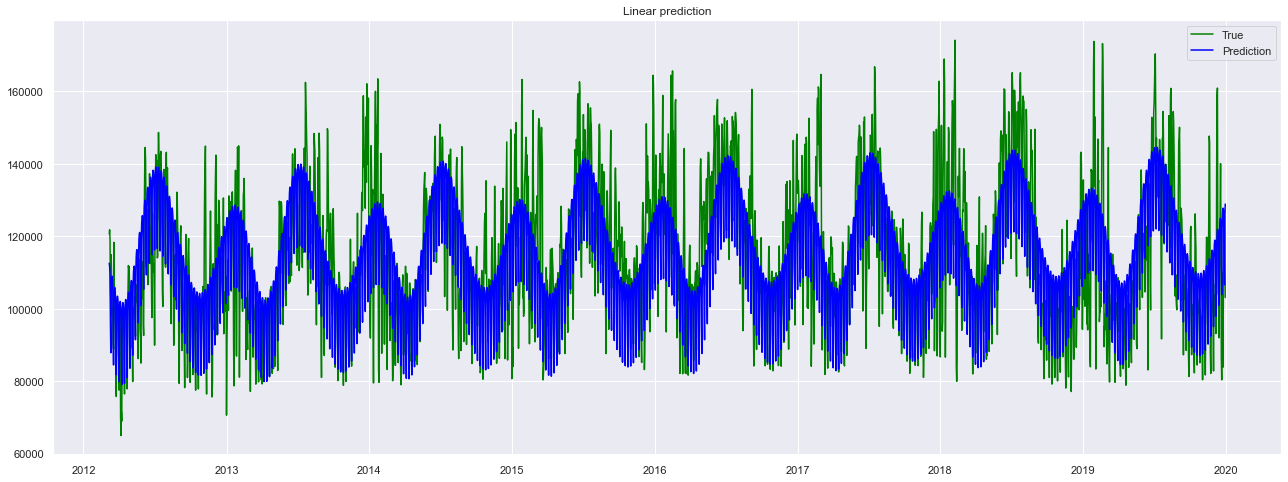

Feature importance: {'f0': 976.0, 'f1': 1568.0}


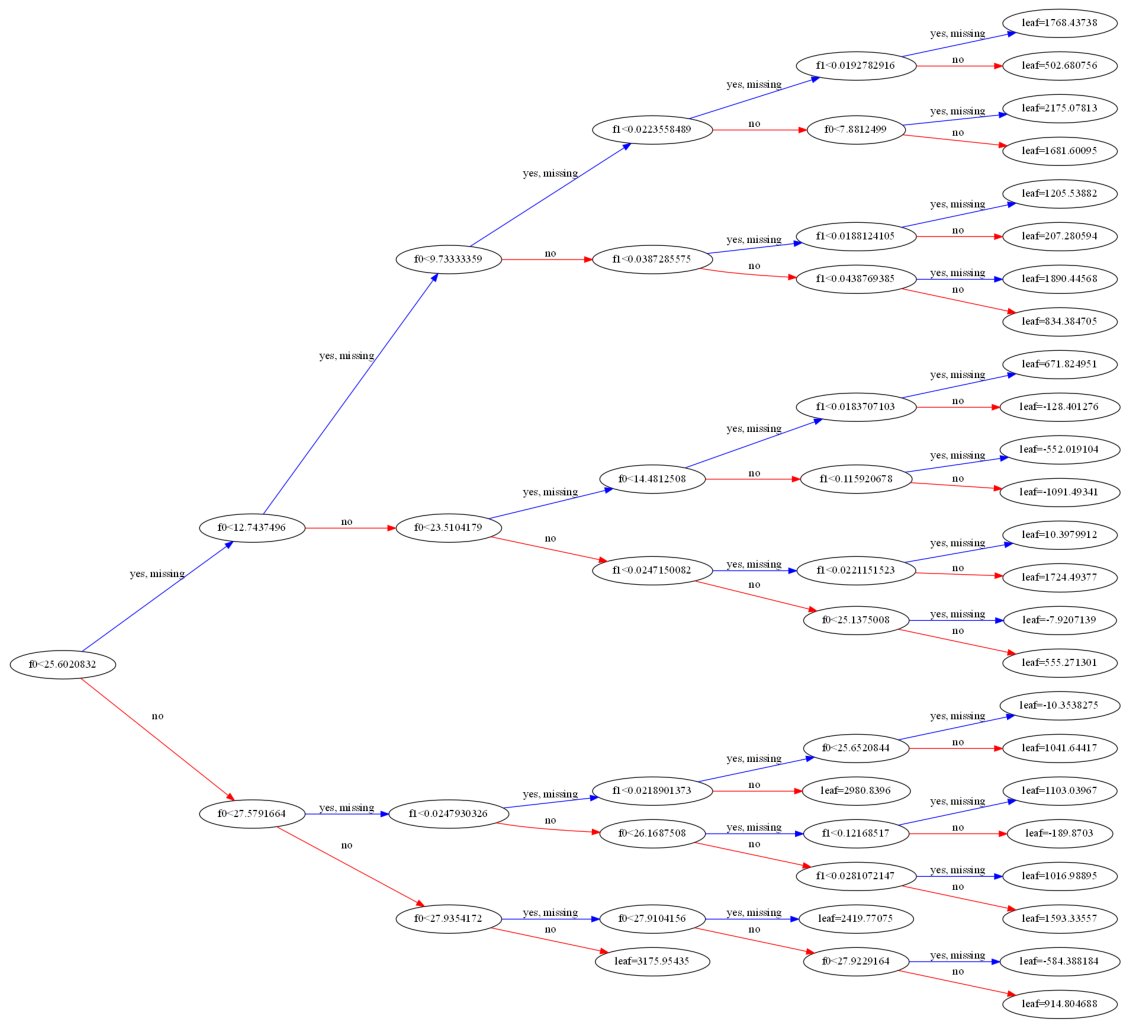

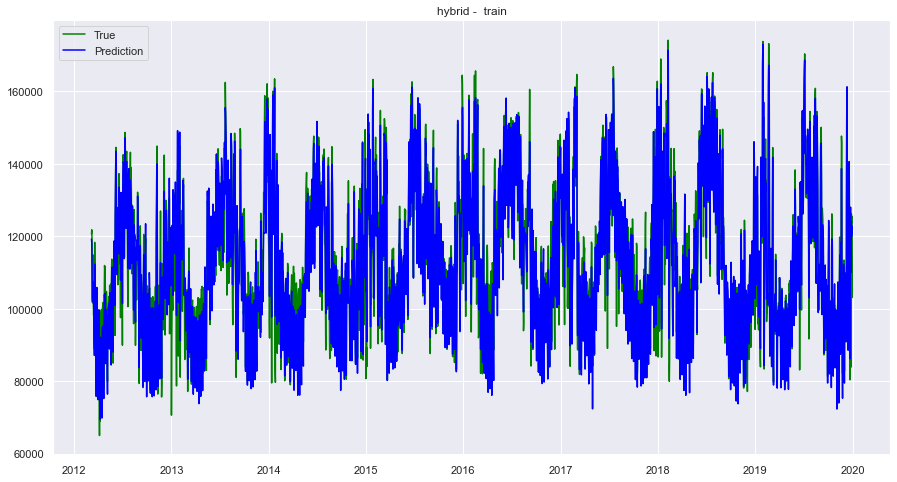

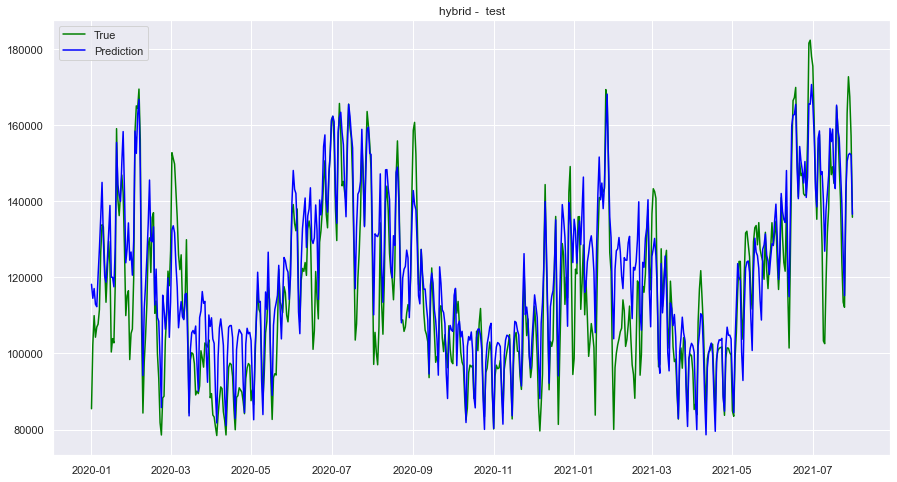

Test - Error cuadratico medio:  118711001.68718849
Test - Error absoluto medio:  8363.803698381264
Test - Error porcentual abs: 0.07661739940798375


7.272823156772024

In [141]:
entrenamiento(train_set,test_set)